# Modelling South Australia's Dec - Mar COVID Outbreak

Due to South Australia's similar dynamics to WA, we try to find pandemix parameters (such as transitivity, latent period, pre symptomatic transmission period) based on the outbreak SA experienced.

In [231]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import math

In [232]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

In [233]:
waloc = pd.read_csv('/Users/Yuval/Desktop/Thesis/all-wa-pos.csv')#use this for all 297 towns
waloc = waloc.loc[waloc['Population'] >0]
# When doing big towns
waloc = waloc[:58]

# When ignoring sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Yanchep') & (waloc['City / Town'] != 'Bullsbrook') &
                  (waloc['City / Town'] != 'Mundijong') & (waloc['City / Town'] != 'Serpentine') &
                 (waloc['City / Town'] != 'Two Rocks') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

# When also ignoring rural satellites
waloc = waloc.loc[(waloc['City / Town'] != 'Pinjarra') & (waloc['City / Town'] != 'Drummond Cove') &
                  (waloc['City / Town'] != 'Bridgetown') & (waloc['City / Town'] != 'Binningup') &
                 (waloc['City / Town'] != 'Dampier') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

# When also ignoring 0 flow towns
waloc = waloc.loc[(waloc['City / Town'] != 'Kununurra') & (waloc['City / Town'] != 'Derby') &
                  (waloc['City / Town'] != 'Boddington-Ranford') & (waloc['City / Town'] != 'Wyndham')]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

In [252]:
# WA Data Processing
wa_data = pd.read_csv('/Users/Yuval/Desktop/Thesis/wa_health.csv')

# Daily cases
wa_totals = list(wa_data.iloc[0])[1:]
wa_totals = [i - 1134 for i in wa_totals]
wa_infs = [0]
for i in range(1,len(wa_totals)):
    wa_infs.append(wa_totals[i]-wa_totals[i-1])
    
total_popn = sum(list(waloc['Population']))

# WA's population is 2491996 people over 5
# https://www.health.gov.au/sites/default/files/documents/2022/02/covid-19-vaccine-rollout-update-1-february-2022.pdf
# There are 377018 people between 5-15, so normalise the third dose based on that

first = list(wa_data.loc[wa_data['Source'] == 'COVID-live First Doses 5+'].iloc[0])[1:]
first = [round(i/2491996*total_popn) for i in first]
first_change = []
for f in range(len(first)-1):
    first_change.append(first[f+1] - first[f])

second = list(wa_data.loc[wa_data['Source'] == 'COVID-live Second Doses 5+'].iloc[0])[1:]
second = [round(i/2491996*total_popn) for i in second]
second_change = []
for f in range(len(second)-1):
    second_change.append(second[f+1] - second[f])

third = list(wa_data.loc[wa_data['Source'] == 'COVID-live Booster Doses 16+'].iloc[0])[1:]
third = [round(i*2491996/(2491996-377018)) for i in third]
third = [round(i/2491996*total_popn) for i in third]
third_change = []
for f in range(len(third)-1):
    third_change.append(third[f+1] - third[f])

uptakes = [first_change, second_change, third_change]

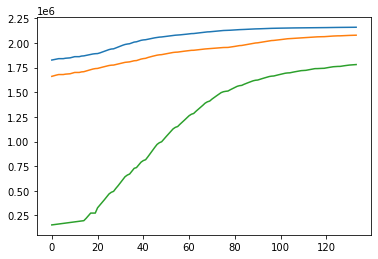

In [253]:
plt.plot(first)
plt.plot(second)
plt.plot(third)

In [254]:
# Make it so there are no negatives (there were only two when I checked)
for i in range(len(uptakes)):
    for j in range(len(uptakes[i])):
        if uptakes[i][j] < 0:
            print(i,j)
            uptakes[i][j] = 0

0 103
0 110


In [255]:
# Find initial values

init_first_dose = list(wa_data.loc[wa_data['Source'] == 'COVID-live First Doses 5+'].iloc[0])[1]
init_first_dose = init_first_dose/2491996
init_second_dose = list(wa_data.loc[wa_data['Source'] == 'COVID-live Second Doses 5+'].iloc[0])[1]
init_second_dose = init_second_dose/2491996
init_third_dose = list(wa_data.loc[wa_data['Source'] == 'COVID-live Booster Doses 16+'].iloc[0])[1]
init_third_dose = init_third_dose*2491996/(2491996-377018)
init_third_dose = init_third_dose/2491996

init1 = init_first_dose- init_second_dose
init2 = init_second_dose - init_third_dose
init3 = init_third_dose

In [256]:
# Five point moving average (for finding inflections)
def moving_average(llist, w_size):
    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []
    
    for j in range(w_size - 1):
        window_average = np.sum(llist[:j+1])/(j+1)
        moving_averages.append(window_average)
        
    while i < len(llist) - w_size + 1:
        window_average = np.sum(llist[i:i+w_size]) / w_size
        moving_averages.append(window_average)
        i += 1
    
    for j in range(w_size - 1):
        window_average = np.sum(llist[len(llist)-w_size+(j+1):])/(j+1)
        

    return moving_averages

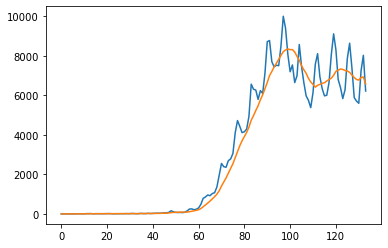

In [257]:
ma = moving_average(wa_infs,7)
plt.plot(wa_infs)
plt.plot(ma)

In [258]:
from scipy.optimize import curve_fit

In [259]:
def sveir(params,x,popn,changes, effic):
    xdot = list(np.zeros(7))
    eff1, eff2, eff3 = effic[0], effic[1], effic[2]
    xdot[0] = -params[0]*x[0]*x[5]/popn - changes[0] # Susceptible
    xdot[1] = -eff1*params[0]*x[1]*x[5]/popn +changes[0] - changes[1]  # First dose
    xdot[2] = -eff2*params[0]*x[2]*x[5]/popn + changes[1] - changes[2] # Second dose
    xdot[3] = -eff3*params[0]*x[3]*x[5]/popn + changes[2] + 1/84*x[6]  # Third dose
    xdot[4] = params[0]*x[0]*x[5]/popn + eff1*params[0]*x[1]*x[5]/popn + eff2*params[0]*x[2]*x[5]/popn + eff3*params[0]*x[3]*x[5]/popn - params[1]*x[4] # Exposed
    xdot[5] = params[1]*x[4] - params[2]*x[5] # Infected
    xdot[6] = params[2]*x[5] - 1/84*x[6] # Removed
    
    infected_daily = params[1]*x[4]
    return xdot, infected_daily

In [422]:
total_popn

2290651

In [386]:
# The big one
def dynamics(x_init,days,steps,a1,a2,a3,a4,uptakes, effic, L, D):
    x = [x_init]
    day_infs = [0]
    
    params = [a1, 1/L, 1/D]
    
    # Iterate over each day
    popul = []
    for day in range(days):
        #Step 1: try the different alphas
        
        if day < 45:
            params[0] = a1
        elif (day>= 45) and (day < 73):
            params[0] = a2
        elif (day >=73) and (day<95):
            params[0] = a3
        elif day>95:
            params[0] = a4
            
        #print(day,params)
            
        changes = [uptakes[0][day],uptakes[1][day], uptakes[2][day]]
        
        # print(day)
        # Step 2: Use the SEIR equation to simulate the spread over the day.
        infected_daily =[]
        for t in range(steps):
            xdot, infs = sveir(params, x[-1], popn,changes,effic)
            xdot = [i/steps for i in xdot]
            x.append([sum(i) for i in zip(*[x[-1],xdot])])
            popul.append(sum(x[-1]))
            infected_daily.append(infs)
        day_infs.append(sum(infected_daily)/steps+day_infs[-1])
        #print(infected_daily, day_infs[-1])
        
    return x, day_infs, popul

In [387]:
def plotting(y):
    s = list(zip(*y))
    plt.figure(figsize = (6,6))
    plt.plot(s[0],'k', label ='Susceptible')
    plt.plot(s[1],label = 'V1')
    plt.plot(s[2],label = 'V2')
    plt.plot(s[3], label = 'V3')
    plt.plot(s[4],'b', label = 'Exposed')
    plt.plot(s[5],'r', label = 'Infected')
    plt.plot(s[6],'y', label = 'Recovered')
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Number of infected")
    plt.xlim([0,steps*days])
    plt.tight_layout()

In [418]:
effic = [1-0.293, 1-0.128, 1-0.58]
# Set the initial town values (when doing final simulations make sure this is accurate)
popn = 2290651
one = 1/popn
x_init = [1-init1 - init2 - init3 - 5*one, init1 - 5*one, init2 - 5*one, init3 - 5*one, 16*one, 4*one,0]
x_init = [x*popn for x in x_init]

# Set number of days for this simulation
days = 133

L = 2.5
D = 4.02110478

# If fitting overall cases
#a1, a2,a3, D =0.97558821, 0.29647689, 0.54174642, 4.02110478
a1, a2,a3,a4 =0.4237464 , 0.92249785, 0.6465886 , 0.48335045
# If fitting daily cases
#a1, a2,a3, D = 2.21435632, 1.27734592, 1.92716264, 1.

params = [a1, 1/L, 1/D]

steps = 12

# Call the function (just once)
y, day_infs, popul = dynamics(x_init,days,steps,a1,a2,a3,a4,uptakes,effic, L, D)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


Text(0.5, 1.0, "Using Adelaide's outbreak to of best fit parameters")

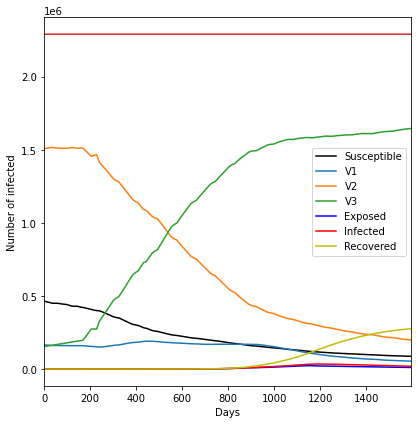

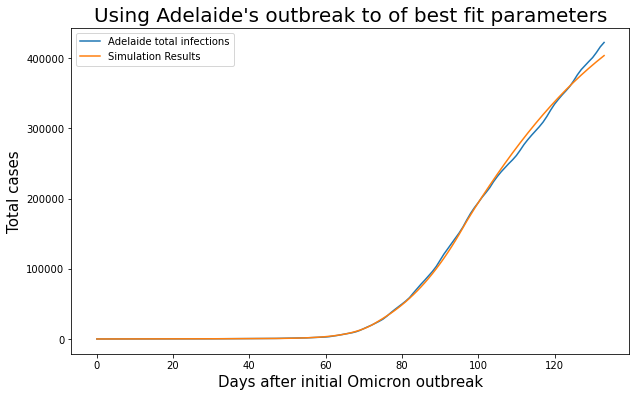

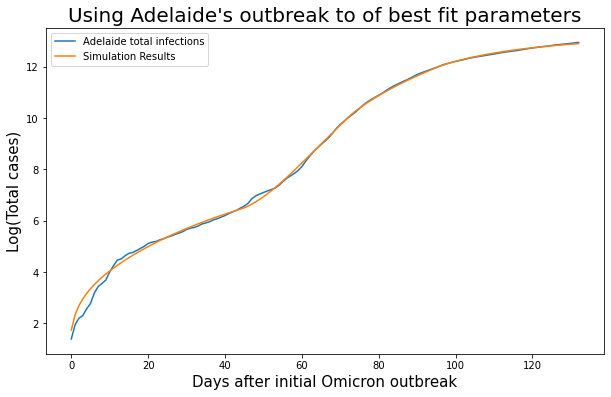

In [419]:
plotting(y)
plt.plot(popul)
plt.figure(figsize = (10,6))
#x = [i/5 for i in range(5*105)]
#plt.plot(x,datt)
plt.plot(wa_totals, label = 'Adelaide total infections')
plt.plot(day_infs, label = 'Simulation Results')
plt.ylabel('Total cases', size = 15)
plt.xlabel('Days after initial Omicron outbreak', size = 15)
plt.legend()
plt.title('Using Adelaide\'s outbreak to of best fit parameters', size =20)
plt.figure(figsize = (10,6))
#x = [i/5 for i in range(5*105)]
#plt.plot(x,datt)
plt.plot(list(np.log(wa_totals))[1:], label = 'Adelaide total infections')
plt.plot(list(np.log(day_infs))[1:], label = 'Simulation Results')
plt.ylabel('Log(Total cases)', size = 15)
plt.xlabel('Days after initial Omicron outbreak', size = 15)
plt.legend()
plt.title('Using Adelaide\'s outbreak to of best fit parameters', size =20)

In [420]:
daily_infs = [0]
for i in range(1,len(day_infs)):
    daily_infs.append(day_infs[i]- day_infs[i-1])

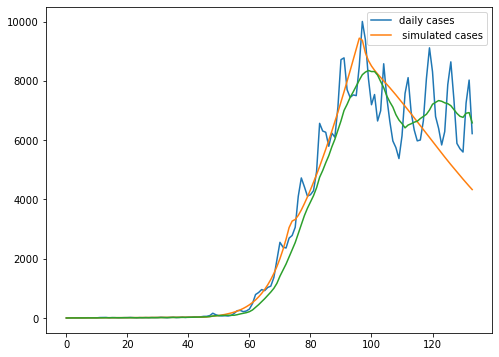

In [421]:
plt.figure(figsize = (8,6))
#plt.plot(ma, label = '7 day moving average')
plt.plot(wa_infs, label = 'daily cases')
plt.plot(daily_infs, label = ' simulated cases')
plt.plot(ma)
plt.legend()

In [402]:
ma.index(max(ma))

99

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


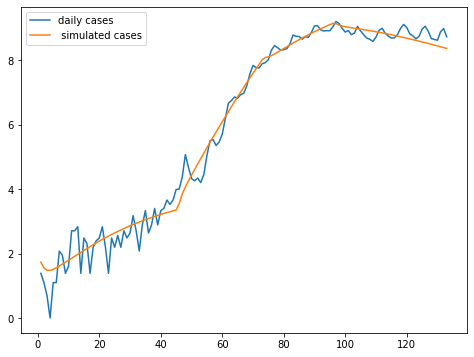

In [403]:
plt.figure(figsize = (8,6))
#plt.plot(ma, label = '7 day moving average')
plt.plot(np.log(wa_infs), label = 'daily cases')
plt.plot(np.log(daily_infs), label = ' simulated cases')
plt.legend()

Have decided to set L=2.5 for now because this paper (https://academic.oup.com/cid/advancearticle/doi/10.1093/cid/ciab746/6359063fbclid=IwAR2CVp4AJAKuwMINxcVlpATDsBWW4StKerqlGYlMwwd5jqOFDaBsaKbmAWg&login=false) has stated that they estimated latent period to be 5.5 days and incubation period to be 6.9 days. However, this is pre-omicron figures. The WHO report Shannon sent says incubation period is about 2.9 to 3.2, so taking 5.5/6.9*3.15 = 2.5

In [394]:
L = 2.5

In [415]:
def func(x, a1, a2, a3,a4):
    y, day_infs, popul = dynamics(x_init,days,steps,a1,a2,a3,a4,uptakes,effic, L, D)
    return list(np.log(day_infs))[1:] # if fitting log cases
    # If fitting daily cases
    #daily_infs = [0]
    #for i in range(1,len(day_infs)):
    #    daily_infs.append(day_infs[i]- day_infs[i-1])
    #return list(daily_infs)[:]
    #return list(day_infs)[1:]

In [416]:
x = [i for i in range(1,len(wa_totals))]
y = list(np.log(wa_totals))[1:]
#y = list(wa_totals)[1:]
#y = ma # if fitting daily cases

popt, pcov = curve_fit(func, x, y,bounds = ([0.1,0.1,0.1,0.1],[3,3,3,3]))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [417]:
popt

array([0.4237464 , 0.92249785, 0.6465886 , 0.48335045])